# Coverage Analysis on HMP data   

Quang Nguyen   
Last updated 2022-04-30   

In [1]:
library(TaxaSetsUtils);
library(BiocSet);
library(curatedMetagenomicData);
library(HMP16SData);
library(tidyverse);
library(phyloseq);
library(DivNet);
library(here);
here::i_am("notebooks/coverage.ipynb")
source(here("R", "generate_scores_func.R"))
options(getClass.msg=FALSE) # suppress phylo class phyloseq::

Loading required package: dplyr

Warning message:
"package 'dplyr' was built under R version 4.1.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'httr':
  method           from  
  print.cache_info hoardr

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats

Warning message:
"package 'matrixStats' was built under R version 4.1.3"

Attaching package: 'matrixStats'


The following object is masked from 'package:dplyr':

    count



Attaching package: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    c

## 16S HMP data  

Here, we load the V3-V5 data set from the Human Microbiome Project  

In [2]:
data <- V35() %>% as_phyloseq();
data

snapshotDate(): 2021-10-19

see ?HMP16SData and browseVignettes('HMP16SData') for documentation

loading from cache

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by 'tidytree'

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by 'tidytree'

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by 'tidytree'

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by 'tidytree'

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by 'tidytree'

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by 'tidytree'

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by 'tidytree'



phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 45336 taxa and 4743 samples ]
sample_data() Sample Data:       [ 4743 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 45336 taxa by 6 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 45336 tips and 45099 internal nodes ]

Here we attach NCBI identifiers onto the main `phyloseq` object

In [3]:
ncbi_attached <- mapid(obj = data, type = "name") 

Using GENUS to match

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by 'tidytree'

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by 'tidytree'

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by 'tidytree'

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by 'tidytree'



In [4]:
tax_table(ncbi_attached) %>% head()

,SUPERKINGDOM,PHYLUM,CLASS,ORDER,FAMILY,GENUS,ncbi
OTU_97.15099,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,1301
OTU_97.13686,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,1301
OTU_97.30326,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,1301
OTU_97.26112,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,1301
OTU_97.34719,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,1301
OTU_97.12776,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,1301


We're going to assess the diversity of OTUs and traits associated with each body subsite. The richness and evenness estimation would be done via `DivNet` and `breakaway`

In [67]:
body_sites <- sample_data(ncbi_attached) %>% as(., "data.frame") %>% 
        dplyr::select(HMP_BODY_SITE, HMP_BODY_SUBSITE)
body_subsites <- body_sites %>% pull(HMP_BODY_SUBSITE) %>% unique()
trait_classes <- c("cell_shape", "gram_stain", "metabolism", "motility", "pathways", "sporulation", "substrate")
evaluation <- cross_df(list(
    sites = body_subsites, 
    t_class = trait_classes
))

Let's create some functions

In [83]:
#' This function counts up for each sample the number of sets having 
#' at least 2 present taxa represented  
count_traits <- function(physeq, q_set){
    eset <- q_set %>% es_elementset() %>% as_tibble() 
    tab <- otu_table(physeq) %>% as.matrix()
    print(dim(tab))
    tab[tab > 0] <- 1
    # obtain list of present otus 
    present <- apply(tab, 2, function(x){
        idx <- which(x >= 1)
    })
    present <- map(present, ~rownames(tab)[.x])
    present <- map_dbl(present, ~{
        eset %>% filter(element %in% .x) %>% 
            group_by(set) %>% dplyr::tally() %>% filter(n >= 2) %>% nrow()
    })
    return(present)
}

#' Count the diversity of taxa per sample per set 
count_tax <- function(physeq, q_set, mode){
    mode <- match.arg(mode, c("evenness", "richness"))
    # get all taxa members  
    p_tax <- q_set@element %>% pull(element)
    # filter out the physeq for only taxa that are part of the sets 
    red_physeq <- prune_taxa(taxa_names(subset_physeq) %in% p_tax, subset_physeq)
    # use this reduced table to get a frequency table to calculate 
    freq_table <- build_frequency_count_tables(otu_table(red_physeq) %>% as.matrix())
    if (mode == "richness"){
        output <- map_dbl(freq_table, ~sample_richness(.x)$estimate)
    } else if (mode == "evenness"){
        output <- map_dbl(freq_table, ~sample_shannon(.x)$estimate)
    }
    return(output) 
}

In [78]:
sites <- "Saliva"
t_class <- "cell_shape"

In [84]:
results <- pmap(evaluation, function(sites, t_class){
    print(sites)
    print(t_class)
    s_sites <- sample_data(ncbi_attached)$HMP_BODY_SUBSITE
    subset_physeq <- prune_samples(s_sites == sites, ncbi_attached) %>% 
        filter_taxa(function(x) sum(x > 0) > (0.01*length(x)), TRUE)
    print(phyloseq::n_samples())
    q_sets <- readRDS(file = glue("../output/sets/set_{trait}_genus.rds", trait = t_class))
    q_sets <- recode_sets(subset_physeq, q_sets)
    richness <- count_tax(subset_physeq, q_sets, "richness")
    evenness <- count_tax(subset_physeq, q_sets, "evenness")
    n_traits <- count_traits(subset_physeq, q_sets)
    tibble(
        n_traits = n_traits,
        richness = richness,
        evenness = evenness, 
        site = sites, 
        class = t_class
    )
})

[1] "Stool"
[1] "cell_shape"


Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by 'tidytree'

Joining, by = "ncbi"
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by 'tidytree'

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by 'tidytree'



[1] 8898  319
[1] "Saliva"
[1] "cell_shape"


Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by 'tidytree'

Joining, by = "ncbi"
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by 'tidytree'

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by 'tidytree'



[1] 15730   290


ERROR: [1m[33mError[39m:[22m
[33m![39m Tibble columns must have compatible sizes.
[36m*[39m Size 290: Existing data.
[36m*[39m Size 319: Column `richness`.
[34mi[39m Only values of size one are recycled.


In [61]:
results

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

[[10]]
NULL

[[11]]
NULL

[[12]]
NULL

[[13]]
NULL

[[14]]
NULL

[[15]]
NULL

[[16]]
NULL

[[17]]
NULL

[[18]]
NULL

Joining, by = "element"


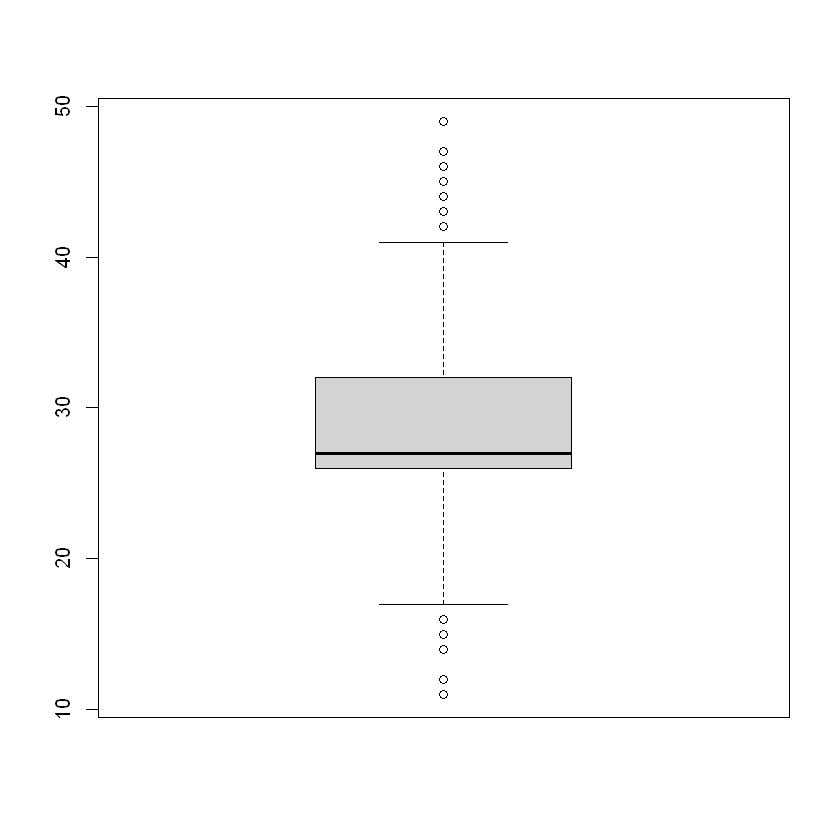

In [99]:
red_physeq <- prune_taxa(taxa_names(subset_physeq) %in% red_taxa, subset_physeq)
freq_table <- build_frequency_count_tables(otu_table(red_physeq) %>% as.matrix())

In [108]:
red_physeq %>% prune_samples(1)

ERROR: Error in (function (classes, fdef, mtable) : unable to find an inherited method for function 'prune_samples' for signature '"phyloseq", "numeric"'


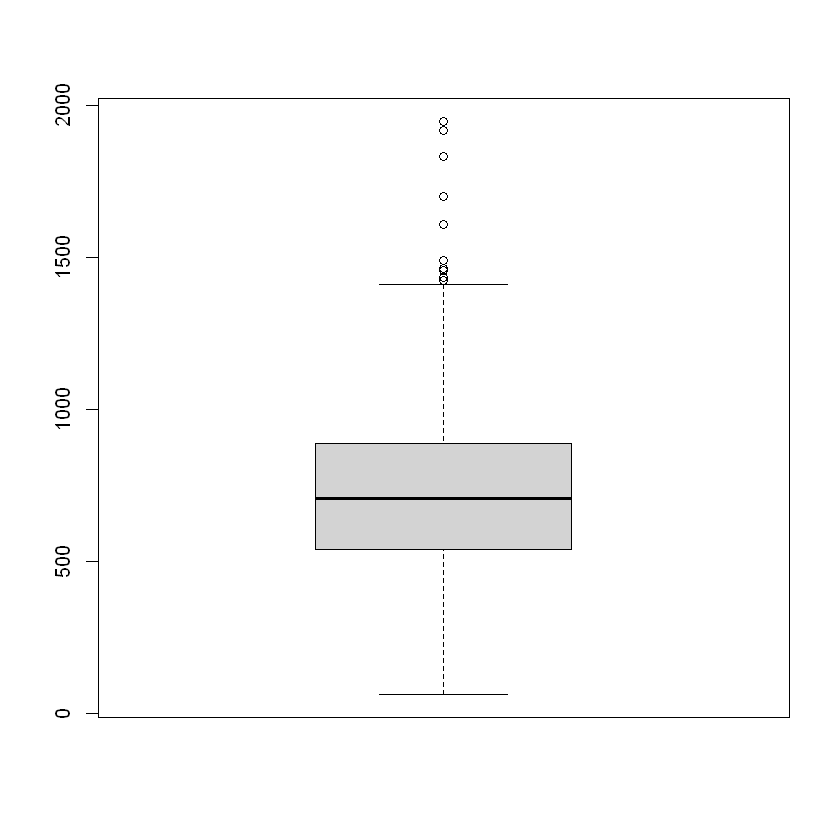

In [98]:
boxplot(richness)

In [91]:
estimate[[1]]

Estimate of richness from method kemp:
  Estimate is 2246
 with standard error 2262.4
  Confidence interval: (661, 418244)
